# Time series EDA

In [57]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# seasonal decomposition
import statsmodels.api as sm

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
# import explore_

# other
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)


# set a default them for all my visuals
sns.set_theme(style="whitegrid")

**Get data**

In [7]:
# load data from existing csv
train = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
train.head()

,bite,year,month,week day,day of month,month number,week day number
dateofbite,,,,,,,
2015-01-01,7,2015,January,Thursday,1,1,3
2015-01-02,9,2015,January,Friday,2,1,4
2015-01-03,7,2015,January,Saturday,3,1,5
2015-01-04,11,2015,January,Sunday,4,1,6
2015-01-05,5,2015,January,Monday,5,1,0


In [8]:
# make sure the index in in time format
train.index = train.index.astype("datetime64")

**Temporal Trends: Are there any noticeable trends in the number of dog bites over time?**

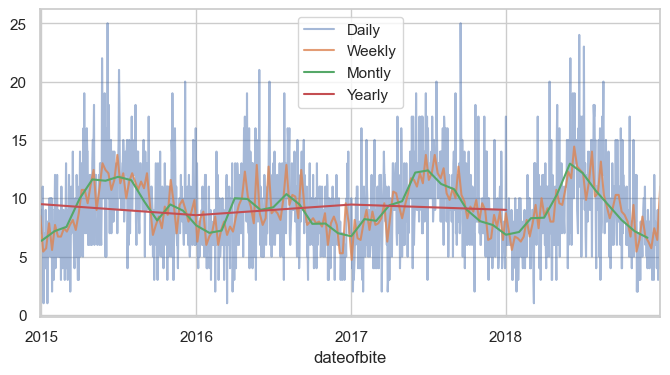

In [9]:
plt.figure(figsize=(8,4))
train.bite.resample('D').mean().plot(alpha=.5, label='Daily')
train.bite.resample('W').mean().plot(alpha=.8, label='Weekly')
train.bite.resample('M').mean().plot(label='Montly')
train.bite.resample('Y').mean().plot(label='Yearly')
plt.legend()

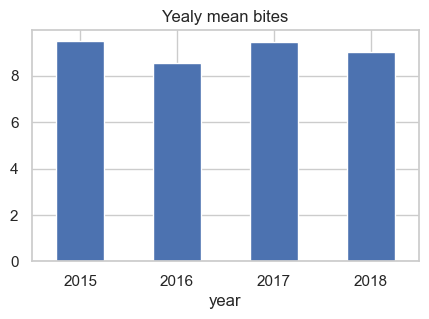

In [10]:
# Yearly mean bits
plt.figure(figsize=(5,3))
train.groupby("year").bite.mean().plot(kind="bar")
plt.title("Yealy mean bites")
plt.xticks(rotation=0)
plt.show()

- About constant level trend over time with a yearly seasonality to the data.

**Seasonal Patterns: Do dog bites exhibit seasonal patterns? Are certain months or seasons associated with a higher number of incidents?**

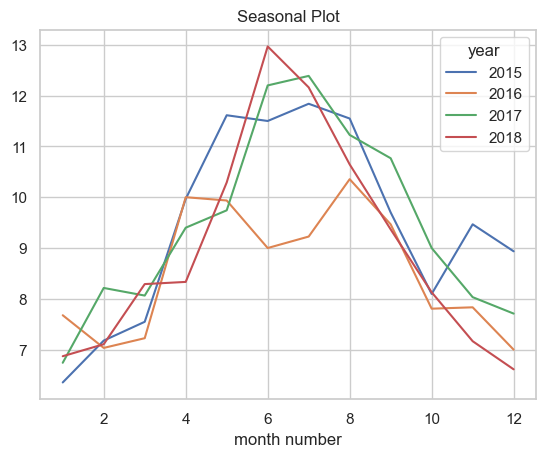

In [11]:
# .unstack turns an index level into columns
train.groupby(["year","month number"]).bite.mean().unstack(0).plot(title='Seasonal Plot')
plt.show()

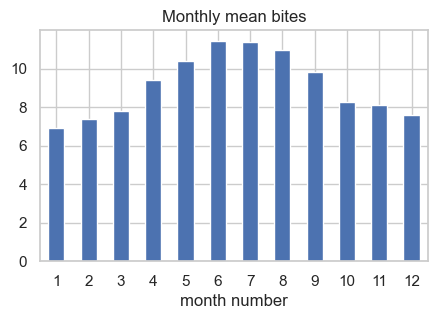

In [12]:
# Yearly mean bits
plt.figure(figsize=(5,3))
train.groupby("month number").bite.mean().plot(kind="bar")
plt.title("Monthly mean bites")
plt.xticks(rotation=0)
plt.show()

- There is a clear seasonal pattern between years
- June and July are with the higher bite average overall.
- There is a large difference in bites between 2016 and 2018 that is not shown in 2017. (Looking at the month of June and July)

**Day of the Week: Are there specific days of the week when dog bites are more frequent than others? Do weekends or weekdays show different patterns?**

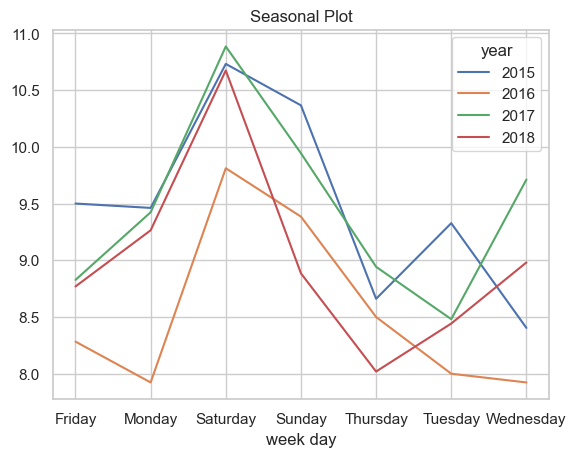

In [13]:
# .unstack turns an index level into columns
train.groupby(["year","week day"]).bite.mean().unstack(0).plot(title='Seasonal Plot')
plt.show()

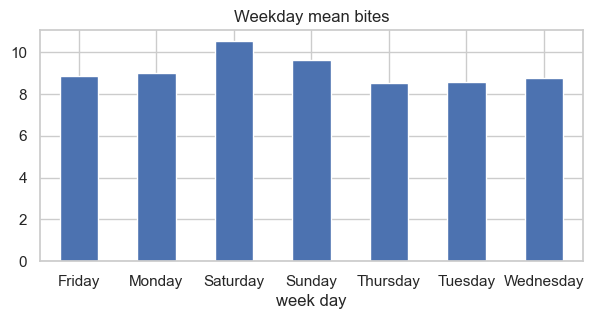

In [14]:
# Yearly mean bits
plt.figure(figsize=(7,3))
train.groupby("week day").bite.mean().plot(kind="bar")
plt.title("Weekday mean bites")
plt.xticks(rotation=0)
plt.show()

- Saturday has the highest concentrated average over all the dayers.
- 2016 has the lowest average Saturday bits overall.
- Weekends have the highest bites rate overall.

**Monthly and Daily Variations: Are there variations in the number of dog bites across different months and days of the month?**

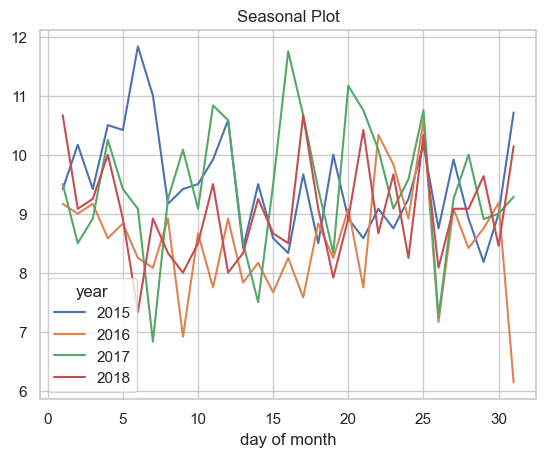

In [19]:
# .unstack turns an index level into columns
train.groupby(["year","day of month"]).bite.mean().unstack(0).plot(title='Seasonal Plot')
plt.show()

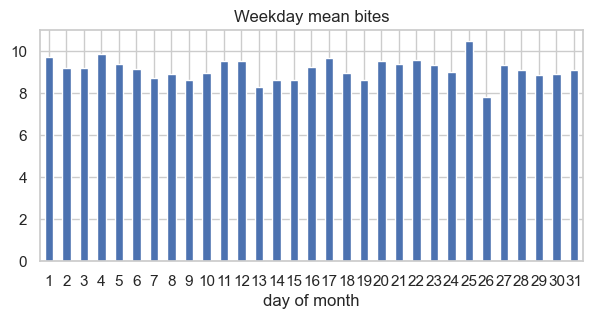

In [21]:
# Yearly mean bits
plt.figure(figsize=(7,3))
train.groupby("day of month").bite.mean().plot(kind="bar")
plt.title("Weekday mean bites")
plt.xticks(rotation=0)
plt.show()

- Day 25 has the highest average but all the days of the month are about the same.

**Outliers: Are there any outlier days or months with exceptionally high or low numbers of dog bites? What are some potential reasons for these outliers?**

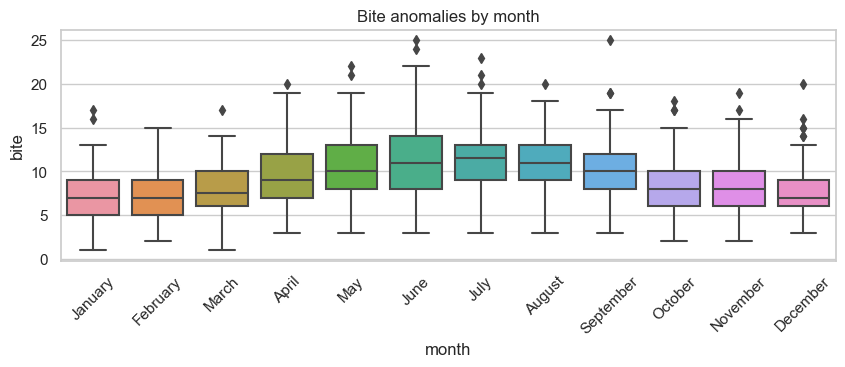

In [32]:
# plot bite outliers by month
plt.figure(figsize=(10,3))
sns.boxplot(data=train, x=train["month"], y='bite')
plt.title('Bite anomalies by month')
plt.xticks(rotation=45)
plt.show()

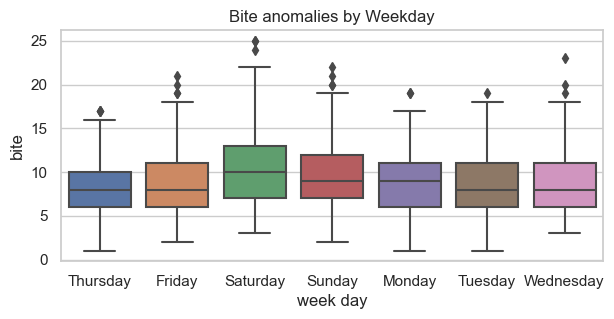

In [28]:
# plot bite outliers by weekday
plt.figure(figsize=(7,3))
sns.boxplot(data=train, x=train["week day"], y='bite')
plt.title('Bite anomalies by Weekday')
plt.show()

- September and December have outliers that are extended more than usual.
- The only consenting outlier on weekdays is on Wednesday.

**Day-to-Day Variability: How much does the number of dog bites vary from one day to the next? Is there any evidence of autocorrelation, where the number of bites on one day is related to the number on the previous day?**

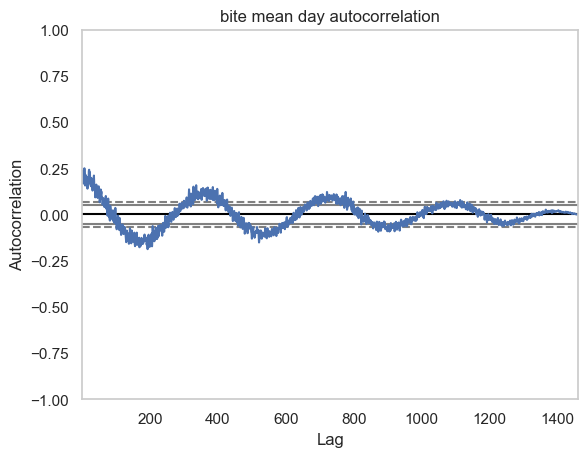

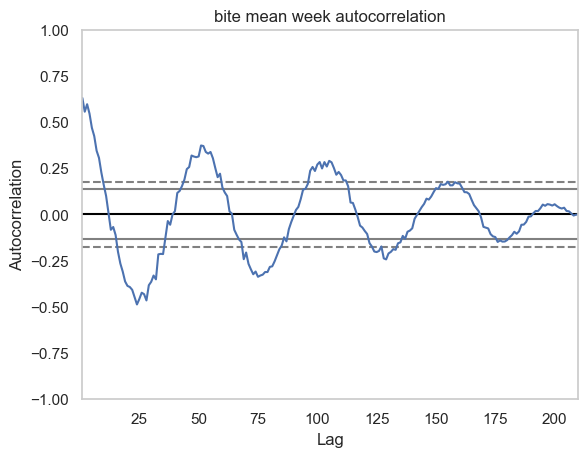

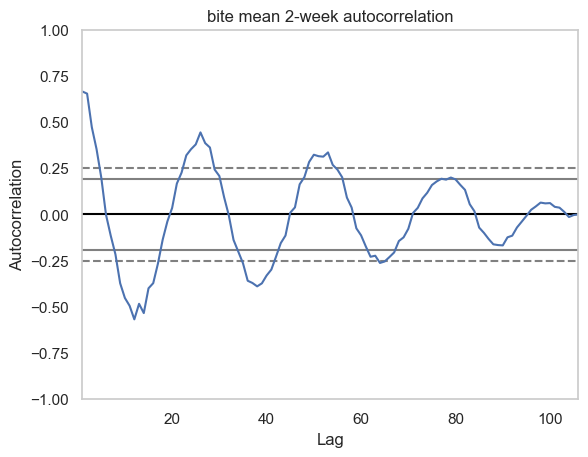

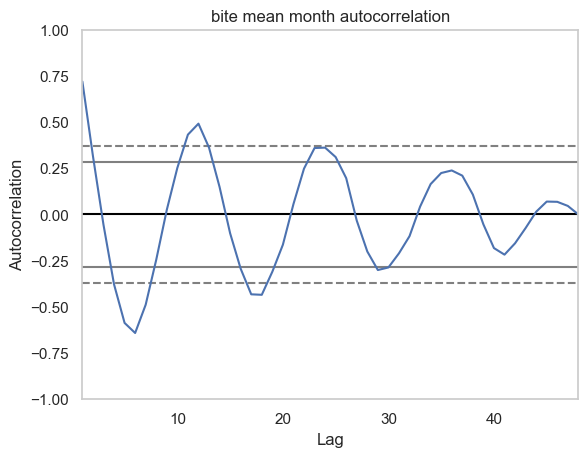

In [40]:
# auto correlation plot between differnt time periods
pd.plotting.autocorrelation_plot(train.bite.resample('D').mean())
plt.title("bite mean day autocorrelation")
plt.show()

pd.plotting.autocorrelation_plot(train.bite.resample('W').mean())
plt.title("bite mean week autocorrelation")
plt.show()

pd.plotting.autocorrelation_plot(train.bite.resample('2W').mean())
plt.title("bite mean 2-week autocorrelation")
plt.show()

pd.plotting.autocorrelation_plot(train.bite.resample('m').mean())
plt.title("bite mean month autocorrelation")
plt.show()

- Bite mean week autocorrelation looks to be more steady than all the others. (Might be a better re-sample to more to modeling)

Text(0.5, 1.0, 'Lag plot with lag=1')

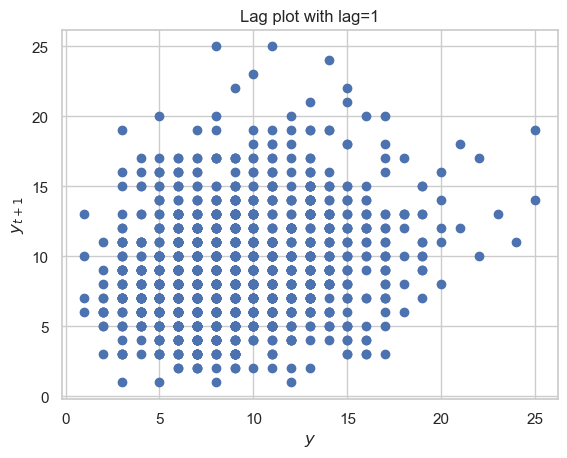

In [41]:
plt.scatter(train.bite, train.bite.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


- I see no strong pattern here

,this_week,year,day of month,month number,week day number,half_year_later
dateofbite,,,,,,
2018-12-30,6.428571,2018.0,27.0,12.0,3.0,9.857143
2019-01-06,11.000000,2018.0,31.0,12.0,0.0,11.428571


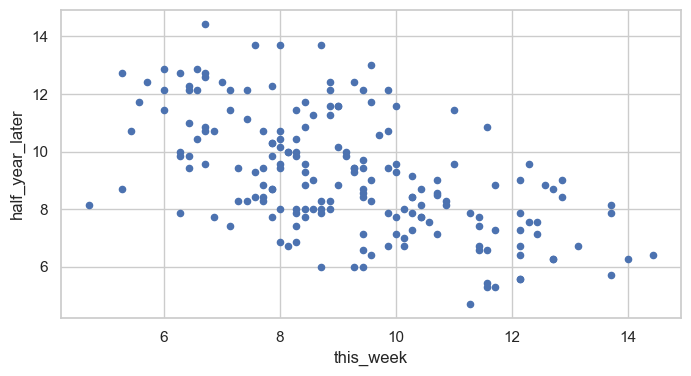

In [56]:
weekly = train.resample('W').mean()
weekly['half_year_later'] = weekly.bite.shift(--24)
weekly = weekly.rename(columns={'bite': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_year_later', figsize=(8, 4))
weekly.tail(2)

- Here I see a negative linear relationship but doesn't look very strong.

**Seasonal decomposition**

In [58]:
y = train.bite.resample('W').mean()

# Seasonal decomposition using moving averages.
result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
dateofbite,,,,
2015-01-04,8.500000,NaN,-1.103241,NaN
2015-01-11,5.428571,NaN,-2.578058,NaN
2015-01-18,5.714286,NaN,-1.287765,NaN
2015-01-25,7.857143,NaN,-2.142160,NaN
2015-02-01,5.571429,NaN,-2.774029,NaN


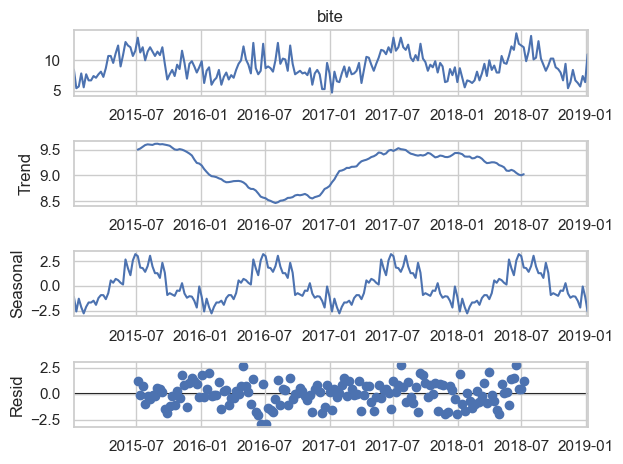

In [59]:
# plot the value returned from seasonal_decompose
result.plot()
None


- The trend has no linearity to it but it shows a seasonal pattern
- The seasonality looks to be over a year at a time
- The residual is not steady, this shows iregulations in the data.

**Takeaways**

Temporal Trends:
- About constant level trend over time with a yearly seasonality to the data.

Seasonal Patterns:
- There is a clear seasonal pattern between years
- June and July are with the higher bite average overall.
- There is a large difference in bites between 2016 and 2018 that is not shown in 2017. (Looking at the month of June and July)

Day of the Week:
- Saturday has the highest concentrated average over all the dayers.
- 2016 has the lowest average Saturday bits overall.
- Weekends have the highest bites rate overall.

Monthly and Daily Variations:
- Day 25 has the highest average but all the days of the month are about the same.

Outliers:
- September and December have outliers that are extended more than usual.
- The only consenting outlier on weekdays is on Wednesday.

Day-to-Day Variability:
- Bite mean week autocorrelation looks to be more steady than all the others. (Might be a better re-sample to more to modeling)
- Here I see a negative linear relationship but doesn't look very strong.

Seasonal decomposition:
- The trend has no linearity to it but it shows a seasonal pattern
- The seasonality looks to be over a year at a time
- The residual is not steady, this shows iregulations in the data.